# Dynamic Double Machine Learning

In [71]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, Ridge, LinearRegression, LogisticRegressionCV, RidgeCV
from sklearn.model_selection import cross_val_predict

In [72]:
COLORS = [
    '#00B0F0',
    '#FF0000',
    '#B0F000'
]


def plot_effect(effect_true, effect_pred, figsize=(8, 5)):
    plt.figure(figsize=figsize) #, dpi=250)
    plt.scatter(effect_true, effect_pred, color=COLORS[0])
    plt.plot(np.sort(effect_true), np.sort(effect_true), color=COLORS[1], alpha=.7, label='Perfect model')
    plt.xlabel('True\ effect$', fontsize=14)
    plt.ylabel('Predicted\ effect$', fontsize=14)
    plt.legend()
    plt.show()

## Data Generating Process

##### Linear Markovian Process:
$$ \forall t \in \{1,\dots,m\}$$ 
$$ X_t = A T_{t-1} + B X_{t-1} + \eta_t $$
$$ T_t = p(T_{t-1},X_t,\zeta_t)$$
$$ Y_t = \theta^{'}_{0}T_t+\mu^{'}X_t+\epsilon_t $$

##### Assumptions:
Errors are exogenous mean-zero random shocks, independent of all contomporaneous and laged treatments and states drawn i.i.d. across time. T0 = X0 = 0

Since we are only concerned w/ final outcome Ym, we will build out methodology as such.

![Screen Shot 2023-11-27 at 1.18.24 PM.png](<attachment:Screen Shot 2023-11-27 at 1.18.24 PM.png>)
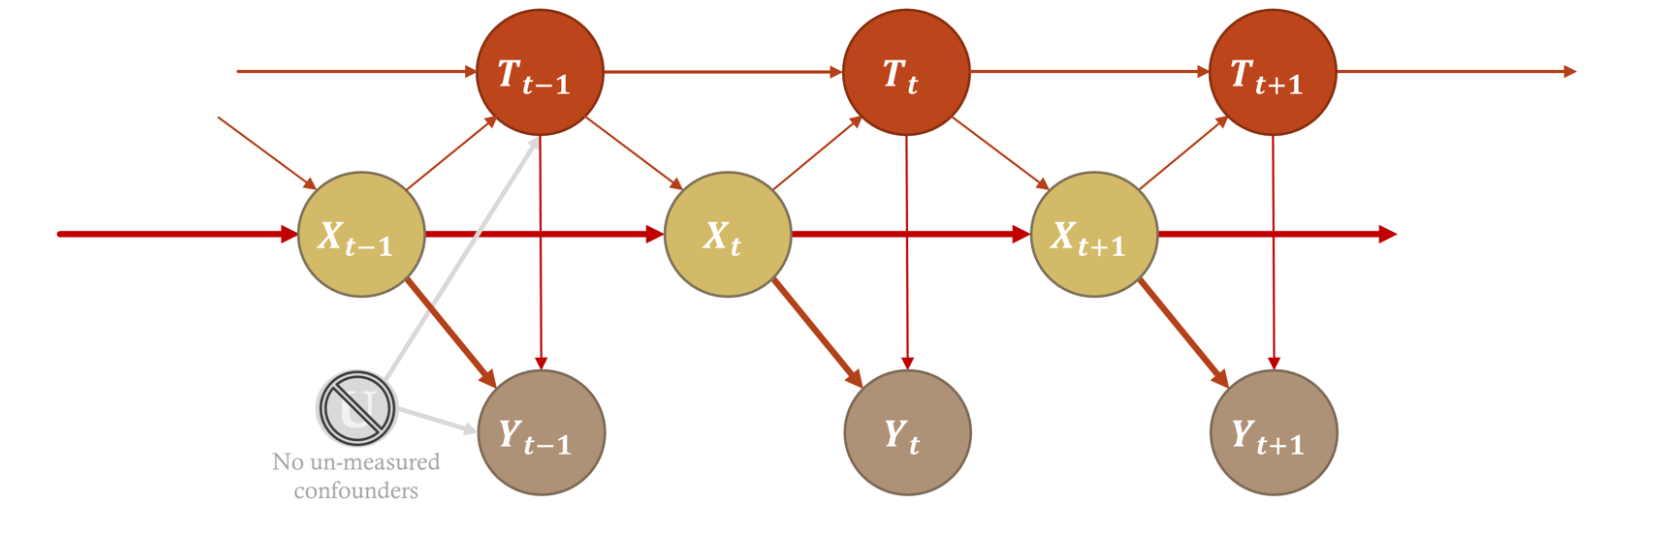

In [73]:
def gen_stationary_square_coef_matrix(n_feats):
    Q = np.random.uniform(low=-0.5,high=0.9,size=(n_feats,n_feats))
    Λ = np.eye(n_feats,n_feats)*np.random.uniform(low=-0.5,high=0.9,size=n_feats)
    B = np.linalg.inv(Q) @ Λ @ Q
    return B

def sigmoid(x):
    return 1/(1+np.exp(-x))

In [222]:
np.random.seed(00)
N = 1_000
n_feats = 10
m = 10

# Variables
T, X, Y = np.zeros(shape=(m,N,1)), np.zeros(shape=(m,N,n_feats)), np.zeros(shape=(m,N,1))

# Exogenous Shocks
ζ, η, ε =  np.zeros(shape=(m,N,1)), np.zeros(shape=(m,N,n_feats)), np.zeros(shape=(m,N,1))

# Time and ID
id, period = np.zeros(shape=(m,N,1)), np.zeros(shape=(m,N,1))
id[0] = np.array([[i] for i in range(1,N+1)])

# Initial Conditions
X[0] = np.random.normal(size=(N,n_feats))
T[0] = np.random.choice([0,1],p=[0.5,0.5],size=(N,1)) # Gets Coupon

# Parameters
B = gen_stationary_square_coef_matrix(n_feats)
A = abs(np.random.normal(size=(n_feats,1)))
μ = abs(np.random.normal(size=(1,n_feats)))
δ = abs(np.random.normal(size=(1,n_feats)))
θ = 10

# Data Simulation
data = np.zeros(shape=(m,N,n_feats+4))
for t in range(0,m):

    print(f"Simulating Time Period: {t}")

    if t == 0:
        Y[0] = 300 + θ*T[0] + 5 * X[0] @ μ.T # Multiplying X[0] by 5 to make initial conditions vary more
    else:
        # Exogenous Shocks
        η[t] = np.random.normal(size=(N,n_feats)) 
        ζ[t] = np.random.normal(size=(N,1))
        ε[t] = np.random.normal(size=(N,1))

        X[t] = T[t-1] @ A.T + X[t-1] @ B.T + η[t]
        T[t] = np.rint(sigmoid(T[t-1] + X[t] @ δ.T + ζ[t]))
        Y[t] = 300 + θ*T[t] + X[t] @ μ.T + ε[t]
    
    id[t] = np.array([[i] for i in range(1,N+1)])
    period[t] = np.array([[t]]*N)
    data[t] = np.concatenate((period[t],id[t],Y[t],T[t],X[t]),axis=1)

Simulating Time Period: 0
Simulating Time Period: 1
Simulating Time Period: 2
Simulating Time Period: 3
Simulating Time Period: 4
Simulating Time Period: 5
Simulating Time Period: 6
Simulating Time Period: 7
Simulating Time Period: 8
Simulating Time Period: 9


In [223]:
# Create Panel/Longitudinal DataFrame
aggregate_data = np.concatenate([data[t] for t in range(0,m)],axis=0)
panel_df = pd.DataFrame(data=aggregate_data,columns=['period','id','Y','T']+[f'x{i}' for i in range(1,n_feats+1)])
panel_df['id'] = panel_df['id'].astype('int')
panel_df['period'] = panel_df['period'].astype('int')
panel_df = panel_df.set_index(["id"]).sort_index()

panel_df

,period,Y,T,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
id,,,,,,,,,,,,,
1,0,356.947027,0.0,1.764052,0.400157,0.978738,2.240893,1.867558,-0.977278,0.950088,-0.151357,-0.103219,0.410599
1,8,354.200619,1.0,6.345034,5.577415,3.180656,-4.174637,8.747718,0.795631,-2.075636,-5.003034,2.374598,-3.048901
1,7,332.756190,1.0,1.958149,2.363457,4.001386,-1.833517,3.849888,1.829049,-1.853146,-0.668546,0.908563,-0.124349
1,6,334.454438,1.0,3.876656,3.407165,1.421388,-0.183193,4.824637,0.082089,-0.915648,-5.345468,2.116054,-1.972838
1,5,339.832288,1.0,5.106214,5.123455,0.790300,-1.523903,5.266957,-0.588270,-1.239240,-5.737409,1.148927,-1.473931
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000,2,325.605479,1.0,3.726753,0.669463,1.048875,-2.577031,4.963200,0.094205,-2.731727,-2.023032,1.838436,-1.671144
1000,1,324.434090,1.0,3.098955,0.894733,0.690523,-1.578809,2.594774,0.602026,-1.186293,-1.758915,1.097231,-0.057912
1000,0,296.572049,0.0,-0.250906,-0.962750,0.493405,2.133050,0.983888,-1.809282,0.042359,0.516872,-0.032921,1.298111


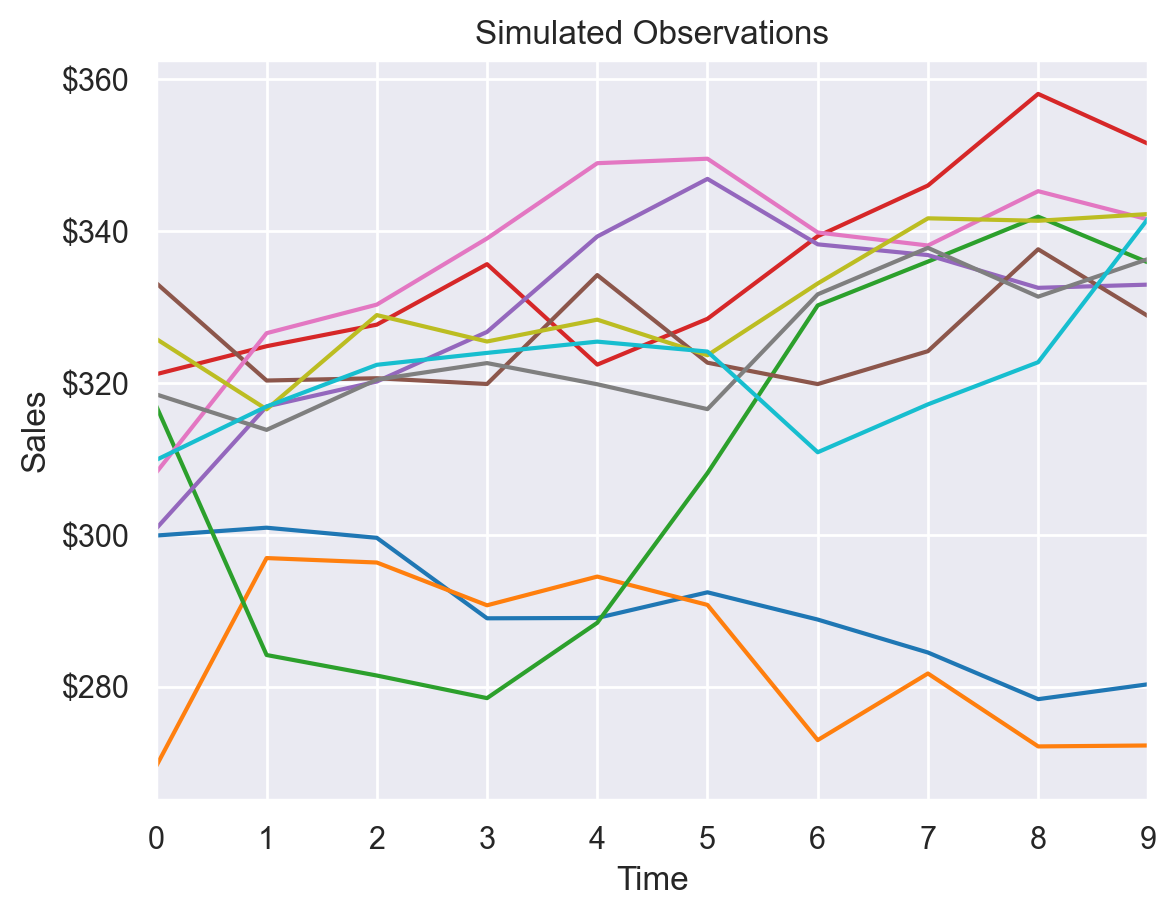

In [224]:
np.random.seed(00)
sns.set_theme(style="darkgrid")

random_observations = np.random.choice(range(1,N),size=10)
filtered_df = panel_df.loc[random_observations]
filtered_df.loc[random_observations[0]]

fig, ax = plt.subplots(dpi=200)
cmap = plt.cm.get_cmap("tab10", 10)
for i in range(0,10):
    sns.lineplot(filtered_df.loc[random_observations[i]],color=cmap(i),x="period",y="Y")
ax.yaxis.set_major_formatter('${x:1.0f}')
ax.set_xlim(0,m-1)
ax.set_title("Simulated Observations")
ax.set_ylabel("Sales")
ax.set_xlabel("Time")
plt.show()

## Baseline Dynamic DML Procedure (Algorithm 1)

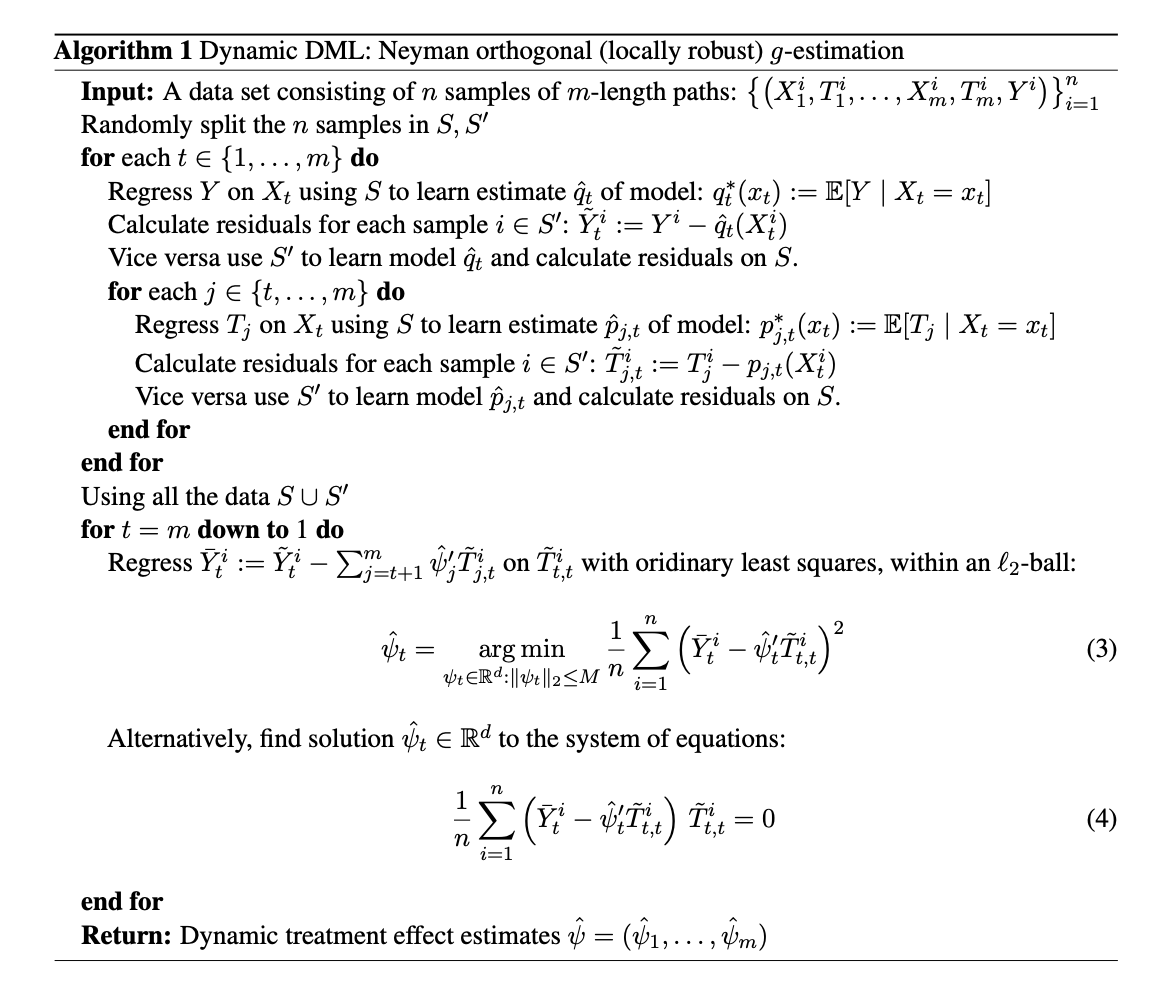

In [225]:
Y_resid = np.zeros(shape=(m,N,1))
T_resid = np.zeros(shape=(m,m,N,1))

for t in range(0,m):
    print(f"Iteration: t = {t}")
    Y_resid[t] = Y[m-1]  - cross_val_predict(Ridge(), X[t], Y[m-1].ravel(), cv=3).reshape(N,1)

    for j in range(t,m):
        print(f"       j = {j}")
        T_resid[j][t] = T[j] - cross_val_predict(LogisticRegression(), X[t], T[j].ravel(), cv=3,method = 'predict_proba')[:,1:].reshape(N,1)

Iteration: t = 0
       j = 0
       j = 1
       j = 2
       j = 3
       j = 4
       j = 5
       j = 6
       j = 7
       j = 8
       j = 9
Iteration: t = 1
       j = 1
       j = 2
       j = 3
       j = 4
       j = 5
       j = 6
       j = 7
       j = 8
       j = 9
Iteration: t = 2
       j = 2
       j = 3
       j = 4
       j = 5
       j = 6
       j = 7
       j = 8
       j = 9
Iteration: t = 3
       j = 3
       j = 4
       j = 5
       j = 6
       j = 7
       j = 8
       j = 9
Iteration: t = 4
       j = 4
       j = 5
       j = 6
       j = 7
       j = 8
       j = 9
Iteration: t = 5
       j = 5
       j = 6
       j = 7
       j = 8
       j = 9
Iteration: t = 6
       j = 6
       j = 7
       j = 8
       j = 9
Iteration: t = 7
       j = 7
       j = 8
       j = 9
Iteration: t = 8
       j = 8
       j = 9
Iteration: t = 9
       j = 9


In [226]:
Y_peeled = np.zeros(shape=(m,N,1))
ψ = np.zeros(shape=(m,1))

for t in range(m-1,-1,-1):

    peel = 0
    if t == m-1:
        Y_peeled[t] = Y_resid[t]
    else:
        for j in range(t+1,m):
            peel += ψ[j]*T_resid[j][t]
        Y_peeled[t] = Y_resid[t] - peel

    Dynamic_DML = LinearRegression(fit_intercept=False).fit(T_resid[t][t],Y_peeled[t])
    ψ[t] = Dynamic_DML.coef_

In [227]:
np.round(ψ,2)

array([[-0.22],
       [ 1.63],
       [-0.4 ],
       [ 2.92],
       [ 6.01],
       [ 0.74],
       [ 8.15],
       [ 2.37],
       [ 9.57],
       [10.3 ]])

In [228]:
np.sum(ψ)

41.07285452760115

Notes: Algorithm 3 (the more complex version of dynamic DML) allows for more complex relationships in the dynamics. Namely, Y & T can be functions of further lagged terms and dynamic treatment policies can take on a much more complex prescription 

### Temp: Calculating Each Period

In [229]:
ψ = np.zeros(shape=(m,m,1))

for m_temp in range(0,m+1):

    Y_resid = np.zeros(shape=(m_temp,N,1))
    T_resid = np.zeros(shape=(m_temp,m_temp,N,1))

    for t in range(0,m_temp):
        print(f"Iteration: t = {t}")
        Y_resid[t] = Y[m_temp-1]  - cross_val_predict(Ridge(), X[t], Y[m_temp-1].ravel(), cv=3).reshape(N,1)

        for j in range(t,m_temp):
            print(f"       j = {j}")
            T_resid[j][t] = T[j] - cross_val_predict(LogisticRegression(), X[t], T[j].ravel(), cv=3,method = 'predict_proba')[:,1:].reshape(N,1)

    Y_peeled = np.zeros(shape=(m_temp,N,1))

    for t in range(m_temp-1,-1,-1):

        peel = 0
        if t == m_temp:
            Y_peeled[t] = Y_resid[t]
        else:
            for j in range(t+1,m_temp):
                peel += ψ[m_temp-1][j]*T_resid[j][t]
            Y_peeled[t] = Y_resid[t] - peel

        Dynamic_DML = LinearRegression(fit_intercept=False).fit(T_resid[t][t],Y_peeled[t])
        ψ[m_temp-1][t] = Dynamic_DML.coef_

Iteration: t = 0
       j = 0
Iteration: t = 0
       j = 0
       j = 1
Iteration: t = 1
       j = 1
Iteration: t = 0
       j = 0
       j = 1
       j = 2
Iteration: t = 1
       j = 1
       j = 2
Iteration: t = 2
       j = 2
Iteration: t = 0
       j = 0
       j = 1
       j = 2
       j = 3
Iteration: t = 1
       j = 1
       j = 2
       j = 3
Iteration: t = 2
       j = 2
       j = 3
Iteration: t = 3
       j = 3
Iteration: t = 0
       j = 0
       j = 1
       j = 2
       j = 3
       j = 4
Iteration: t = 1
       j = 1
       j = 2
       j = 3
       j = 4
Iteration: t = 2
       j = 2
       j = 3
       j = 4
Iteration: t = 3
       j = 3
       j = 4
Iteration: t = 4
       j = 4
Iteration: t = 0
       j = 0
       j = 1
       j = 2
       j = 3
       j = 4
       j = 5
Iteration: t = 1
       j = 1
       j = 2
       j = 3
       j = 4
       j = 5
Iteration: t = 2
       j = 2
       j = 3
       j = 4
       j = 5
Iteration: t = 3
       j = 3
       j = 4
 

In [230]:
np.round(ψ,2)

array([[[ 9.98],
        [ 0.  ],
        [ 0.  ],
        [ 0.  ],
        [ 0.  ],
        [ 0.  ],
        [ 0.  ],
        [ 0.  ],
        [ 0.  ],
        [ 0.  ]],

       [[ 6.75],
        [10.37],
        [ 0.  ],
        [ 0.  ],
        [ 0.  ],
        [ 0.  ],
        [ 0.  ],
        [ 0.  ],
        [ 0.  ],
        [ 0.  ]],

       [[ 3.59],
        [ 6.66],
        [11.11],
        [ 0.  ],
        [ 0.  ],
        [ 0.  ],
        [ 0.  ],
        [ 0.  ],
        [ 0.  ],
        [ 0.  ]],

       [[ 3.98],
        [ 5.46],
        [ 6.75],
        [10.76],
        [ 0.  ],
        [ 0.  ],
        [ 0.  ],
        [ 0.  ],
        [ 0.  ],
        [ 0.  ]],

       [[ 3.22],
        [ 5.77],
        [ 4.01],
        [ 5.55],
        [10.82],
        [ 0.  ],
        [ 0.  ],
        [ 0.  ],
        [ 0.  ],
        [ 0.  ]],

       [[ 1.64],
        [ 5.05],
        [ 4.82],
        [ 4.53],
        [ 7.63],
        [10.79],
        [ 0.  ],
        [ 0.  ],
    

In [207]:
np.sum(ψ)

299.63828267716167

## EconML Example

In [10]:
from econml.panel.dml import DynamicDML

est = DynamicDML(
    model_y=Ridge(), 
    model_t=LogisticRegression(),
    discrete_treatment=True,
    cv=3)

est.fit(Y.flatten(), T.flatten(), X=None, W=X.reshape(10_000,10), groups=id.flatten())

/Users/jakepenzak/Coding/miniconda3/envs/Blog-Posts/lib/python3.10/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/Users/jakepenzak/Coding/miniconda3/envs/Blog-Posts/lib/python3.10/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-

In [11]:
print(est.const_marginal_ate())
print(est.const_marginal_effect())
print(est.summary())

[ 0.09070663  1.8209749  -0.69866309  2.77199677  5.73506149  1.00538925
  8.5982216   2.13621653  8.45479154  9.45570022]
[[ 0.09070663  1.8209749  -0.69866309  2.77199677  5.73506149  1.00538925
   8.5982216   2.13621653  8.45479154  9.45570022]]
Coefficient Results:  X is None, please call intercept_inference to learn the constant!
                              CATE Intercept Results                             
                            point_estimate stderr zstat  pvalue ci_lower ci_upper
---------------------------------------------------------------------------------
cate_intercept|(T0_1.0)$_0$          0.091  0.888  0.102  0.919    -1.65    1.831
cate_intercept|(T0_1.0)$_1$          1.821  2.109  0.863  0.388   -2.313    5.955
cate_intercept|(T0_1.0)$_2$         -0.699  2.046 -0.342  0.733   -4.708    3.311
cate_intercept|(T0_1.0)$_3$          2.772  2.491  1.113  0.266    -2.11    7.654
cate_intercept|(T0_1.0)$_4$          5.735  3.129  1.833  0.067   -0.397   11.867
cate_in

In [12]:
print(est.effect())
print(est.ate_interval())
print(est.ate_inference())

[39.37039584]
(32.66896236895969, 46.071829309946075)
               Uncertainty of Mean Point Estimate               
mean_point stderr_mean zstat  pvalue ci_mean_lower ci_mean_upper
----------------------------------------------------------------
     39.37       3.419 11.515    0.0        32.669        46.072
      Distribution of Point Estimate     
std_point pct_point_lower pct_point_upper
-----------------------------------------
      0.0           39.37           39.37
     Total Variance of Point Estimate     
stderr_point ci_point_lower ci_point_upper
------------------------------------------
       3.419         32.669         46.072
------------------------------------------


## Dynamic DML Procedure for the CATE

In [13]:
np.random.seed(00)
N = 1_000
n_feats = 10
m = 10

# Variables
T, X, Y = np.zeros(shape=(m,N,1)), np.zeros(shape=(m,N,n_feats)), np.zeros(shape=(m,N,1))

# Exogenous Shocks
ζ, η, ε =  np.zeros(shape=(m,N,1)), np.zeros(shape=(m,N,n_feats)), np.zeros(shape=(m,N,1))

# Time and ID
id, period = np.zeros(shape=(m,N,1)), np.zeros(shape=(m,N,1))
id[0] = np.array([[i] for i in range(1,N+1)])


# Initial Conditions
X[0] = np.random.normal(size=(N,n_feats))
T[0] = np.random.choice([0,1],p=[0.5,0.5],size=(N,1)) # Gets Coupon

# Parameters
B = gen_stationary_square_coef_matrix(n_feats)
A = abs(np.random.normal(size=(n_feats,1)))
μ = abs(np.random.normal(size=(1,n_feats)))
δ = abs(np.random.normal(size=(1,n_feats)))
θ = 10
θ_cate = np.random.normal(loc=5,scale=2,size=(1,n_feats))

# Data Simulation
data = np.zeros(shape=(m,N,n_feats+4))
for t in range(1,m):

    print(f"Simulating Time Period: {t}")

    # Exogenous Shocks
    η[t] = np.random.normal(size=(N,n_feats)) 
    ζ[t] = np.random.normal(size=(N,1))
    ε[t] = np.random.normal(size=(N,1))

    X[t] = T[t-1] @ A.T + X[t-1] @ B.T + η[t]
    T[t] = np.rint(sigmoid(T[t-1] + X[t] @ δ.T + ζ[t]))
    Y[t] = 300 + θ*T[t] + T[t]*X[0] @ θ_cate.T + X[t] @ μ.T + ε[t]
    
    id[t] = np.array([[i] for i in range(1,N+1)])
    period[t] = np.array([[t]]*N)
    data[t] = np.concatenate((period[t],id[t],Y[t],T[t],X[t]),axis=1)

Simulating Time Period: 1
Simulating Time Period: 2
Simulating Time Period: 3
Simulating Time Period: 4
Simulating Time Period: 5
Simulating Time Period: 6
Simulating Time Period: 7
Simulating Time Period: 8
Simulating Time Period: 9


In [14]:
Y_resid = np.zeros(shape=(m,N,1))
T_resid = np.zeros(shape=(m,m,N,1))

for t in range(1,m):
    print(f"Iteration: t = {t}")
    # M_Y = GradientBoostingRegressor()
    Y_resid[t] = Y[m-1]  - cross_val_predict(Ridge(), X[t], Y[m-1].ravel(), cv=3).reshape(N,1)

    for j in range(t,m):
        print(f"       j = {j}")
        # M_T = GradientBoostingClassifier()
        T_resid[j][t] = T[j] - cross_val_predict(LogisticRegression(), X[t], T[j].ravel(), cv=3,method = 'predict_proba')[:,1].reshape(N,1)

Iteration: t = 1
       j = 1
       j = 2


       j = 3
       j = 4
       j = 5
       j = 6
       j = 7
       j = 8
       j = 9
Iteration: t = 2
       j = 2
       j = 3
       j = 4
       j = 5
       j = 6
       j = 7
       j = 8
       j = 9
Iteration: t = 3
       j = 3
       j = 4
       j = 5
       j = 6
       j = 7
       j = 8
       j = 9
Iteration: t = 4
       j = 4
       j = 5
       j = 6
       j = 7
       j = 8
       j = 9
Iteration: t = 5
       j = 5
       j = 6
       j = 7
       j = 8
       j = 9
Iteration: t = 6
       j = 6
       j = 7
       j = 8
       j = 9
Iteration: t = 7
       j = 7
       j = 8
       j = 9
Iteration: t = 8
       j = 8
       j = 9
Iteration: t = 9
       j = 9


In [15]:
Y_peeled = np.zeros(shape=(m,N,1))
interaction = np.zeros(shape=(m,N,n_feats+1))
ψ_model = {}

for t in range(m-1,0,-1):

    peel = 0
    if t == m-1:
        Y_peeled[t] = Y_resid[t]
    else:
        for j in range(t+1,m):
            peel += ψ[j]*T_resid[j][t]
        Y_peeled[t] = Y_resid[t] - peel

    interaction[t] = np.concatenate((T_resid[t][t],T_resid[t][t] * X[0]),axis=1)
    ψ_model[t] = RidgeCV(cv=3,fit_intercept=False).fit(interaction[t], Y_peeled[t])

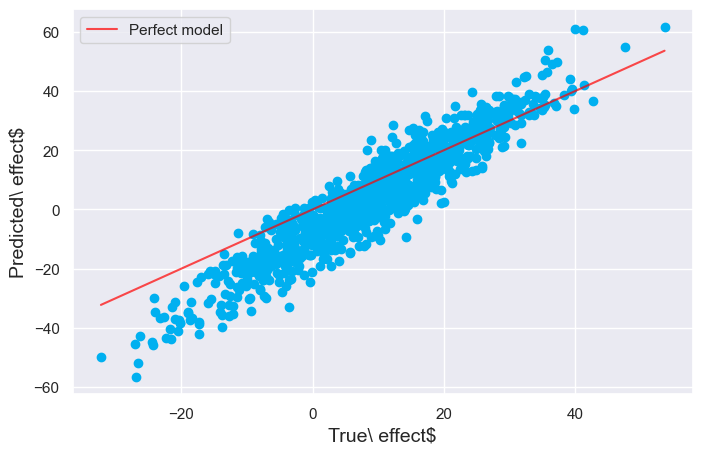

In [16]:
data = np.concatenate((np.array([[1]*N]).T,X[0]),axis=1)

plot_effect((θ + X[0] @ θ_cate.T).ravel(), ψ_model[9].predict(data))

## Econ ML Example

In [19]:
from econml.panel.dml import DynamicDML

est = DynamicDML(
    model_y=Ridge(), 
    model_t=LogisticRegression(),
    discrete_treatment=True,
    cv=3)

est.fit(Y.flatten(), T.flatten(), X=X.reshape(10_000,10), W=None, groups=id.flatten())

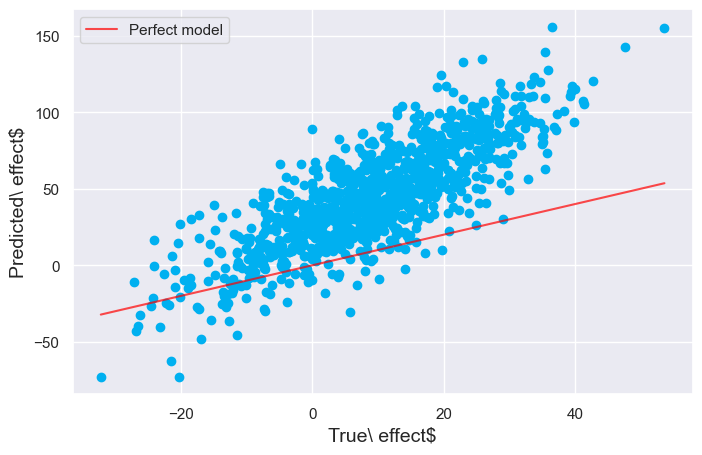

In [20]:
plot_effect((θ + X[0] @ θ_cate.T).ravel(), est.effect(X[0]))